# Phục hồi ảnh bị tác động bởi degradation function

Do tác động của Degration function nên chất lượng ảnh bị suy giảm. <br>
Phục hồi ảnh quan tâm đến việc cải thiện chất lượng ảnh với các phương pháp phù hợp, sử dụng những kiến thức phù hợp về những yếu tố làm thay đổi chất lượng ảnh, cụ thể là *blur* và *nhiễu (noise)*
Trong notebook này, chúng tôi thực hiện qua 2 quá trình <br>
<ol style="padding-bottom: 10px;">
<li> Biến đổi ảnh gốc với degradation functions
<li> Phục hồi ảnh được biến đổi thông qua các bộ lọc phù hợp, đưa ảnh về gần với ảnh gốc
</ol>
Để thuận lợi, ảnh đã được chuyển về ảnh xám.

## Inverse Filter

### 1. Mô phỏng biến đổi ảnh gốc
Xem xét một ảnh, nhóm biến đổi một ảnh thông qua một hàm degration $h(\mathbf{x})$ (đóng vai trò là kernel)



In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from numpy.fft import fft, ifft, fftshift
from scipy.fftpack import fftn, ifftn, fftshift
import math

In [2]:
def degradation_function(M, N, k):
    arx = np.arange(0, M)
    ary = np.arange(0, N)
    u, v = np.meshgrid(arx, ary)
    de_fnc = np.exp(-k*((u-M/2)**2+(v-N/2)**2)**(5/6))
    return de_fnc

def degradation_function_v2(M, N,a=0.1, b=0.1, T=1):
    arx = np.arange(0, M)
    ary = np.arange(0, N)
    u, v = np.meshgrid(arx, ary)
    C = np.pi*(a*(u-M/2)+b*(v-N/2))
    new_c = np.asarray([[x if x !=0 else 0.1 for x in s] for s in C])
    de_fnc = (T/new_c)*np.sin(new_c)*np.exp(-1j*new_c)
    return de_fnc

In [3]:
def gaussian_kernel(k = 5, sigma = 1.0):
    arx = np.arange((-k // 2) + 1.0, (k // 2) + 1.0)
    x, y = np.meshgrid(arx, arx)
    
    filt = np.exp(-0.5 * (np.square(x) + np.square(y)) / np.square(sigma))
    return filt / np.sum(filt)

In [12]:
import cv2
from config import Flag

prefix = Flag.image_origin
file_name = prefix / 'banana.jpg'
im = cv2.imread(str(file_name),0)


Text(0.5, 1.0, 'degraded/blurred image')

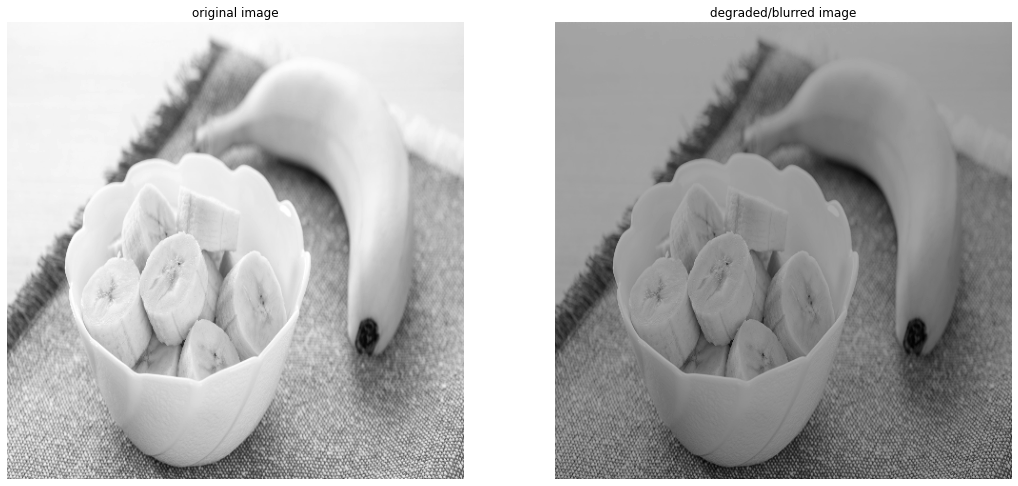

In [33]:
f = cv2.imread(str(file_name),0)
f = cv2.resize(f, (480, 480))

h = gaussian_kernel(k=9, sigma=3)
# computing the number of padding on one side
a = int(f.shape[0]//2 - h.shape[0]//2)
h_pad = np.pad(h, (a,a-1), 'constant', constant_values=(0))

# computing the Fourier transforms
F = fftn(f)
H = degradation_function(f.shape[0], f.shape[1],0.000025)

# plt.subplot(121)
# plt.imshow(fftshift(np.log(np.abs(F)+1)), cmap="gray")
# plt.subplot(122)
# # plt.imshow(np.log(np.abs(H)+1), cmap="gray")
# plt.imshow(H, cmap="gray")

G = np.multiply(F,H)


# Inverse Transform
# - we have to perform FFT shift before reconstructing the image in the space domain
# g =fftshift(ifftn(G).real)
g =(ifftn(G).real)
plt.figure(figsize=(18,10))
plt.subplot(121)
plt.axis("off")
plt.imshow(f, cmap="gray", vmin=0, vmax=255); plt.title("original image")
plt.subplot(122)
plt.axis("off")
plt.imshow(g, cmap="gray", vmin=0, vmax=255); plt.title("degraded/blurred image")

### 2. Sử dụng inverse filter với blured image (chưa có noise)

{'MSE': 1.1338478023545643e-27, 'PSNR': 317.5852559822779}


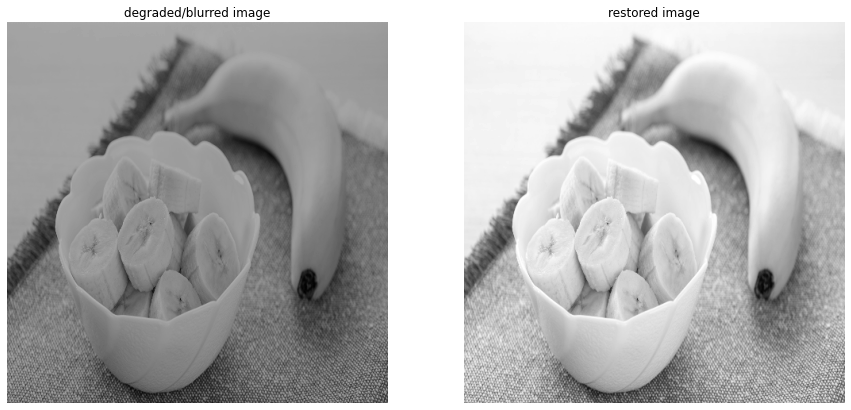

In [32]:
#F_hat = G/H
# H = degradation_function(f.shape[0], f.shape[1],0.00001)
F_hat = np.divide(G,H)

f_hat = ifftn(F_hat).real

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.axis('off')
plt.imshow(g, cmap="gray", vmin=0, vmax=255); plt.title("degraded/blurred image")
plt.subplot(122)
plt.axis('off')
plt.imshow(f_hat, cmap="gray", vmin=0, vmax=255); plt.title("restored image")

def metric(gt, ri):
    SE = (gt - ri)**2
    MSE = SE.mean()
    PSNR = 10*np.log10(255*255/MSE)
    return {"MSE": MSE,"PSNR":PSNR}
metric_inverse = metric(f, f_hat)

print(metric_inverse)

from https://dsp.stackexchange.com/questions/29545/why-does-this-reconstruction-produce-a-phase-shift-from-the-original-signal
The shift is due to using an FFT with a different length than the length of the data, and likely using a non-symmetric arrangement of zero-padding to increase that original length to the zero-padded length.

Non-symmetric zero-padding rotates the phase results of an FFT, spiraling across result bins.

### 2. Sử dụng inverse filter với blured image + noise

## Wiener Filter

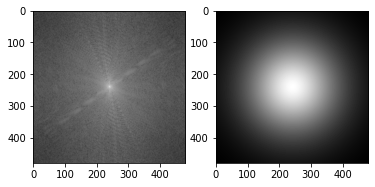

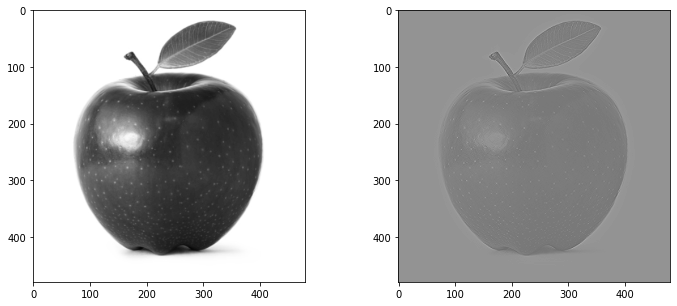

In [51]:
file_name = prefix / 'apple.jpg'
f_wiener = cv2.imread(str(file_name),0)
f_wiener = cv2.resize(f_wiener, (480, 480))

# h = gaussian_kernel(k=11, sigma=3)
# a = int(f.shape[0]//2 - h.shape[0]//2)
# h_pad = np.pad(h, (a,a-1), 'constant', constant_values=(0))

F = fftn(f_wiener)
H = degradation_function(f.shape[0], f.shape[1], 0.00025)
G = np.multiply(F,H)

plt.subplot(121)
plt.imshow(fftshift(np.log(np.abs(F)+1)), cmap="gray")
plt.subplot(122)
# plt.imshow(np.log(np.abs(H)+1), cmap="gray")
plt.imshow(H, cmap="gray")

g = (ifftn(G).real)

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(f_wiener, cmap='gray')
plt.subplot(122)
plt.imshow(g, cmap='gray')



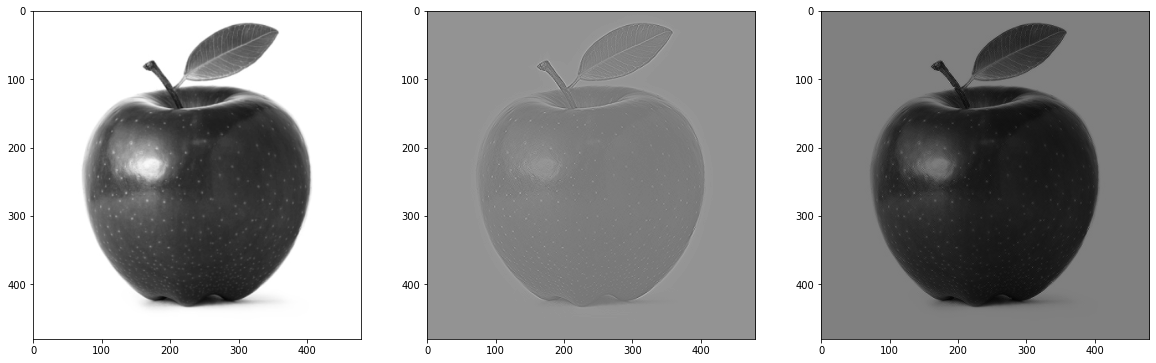

In [59]:
K = 0.025
K_degradation = 0.00025
# plt.imshow(g, cmap='gray')
im_noise = np.copy(g)
G_wiener = fftn(im_noise)
# h_wiener = gaussian_kernel(k=9,sigma = 2)

#bien doi ham degradation sang mien tan
# h_wiener_pad = np.zeros(im_noise.shape)
# h_wiener_pad[:h_wiener.shape[0], :h_wiener.shape[1]] = np.copy(h_wiener)
H_wiener = degradation_function(f.shape[0], f.shape[1], K_degradation)

#wiener function
weiner_term = (abs(H_wiener)**2)/(abs(H_wiener)**2 + K)
H_weiner = (1/H_wiener)*weiner_term
F_wiener = G_wiener/H_weiner
f_hat = ifftn(F_wiener).real
restored = abs(f_hat)

#plot fig
plt.figure(figsize=(20,12))
plt.subplot(131)
plt.imshow(f_wiener, cmap='gray')
plt.subplot(132)
plt.imshow(im_noise, cmap='gray')
plt.subplot(133)
plt.imshow(restored, cmap='gray')       


## Constrained Least Squares Filtering

### Voi Y co dinh

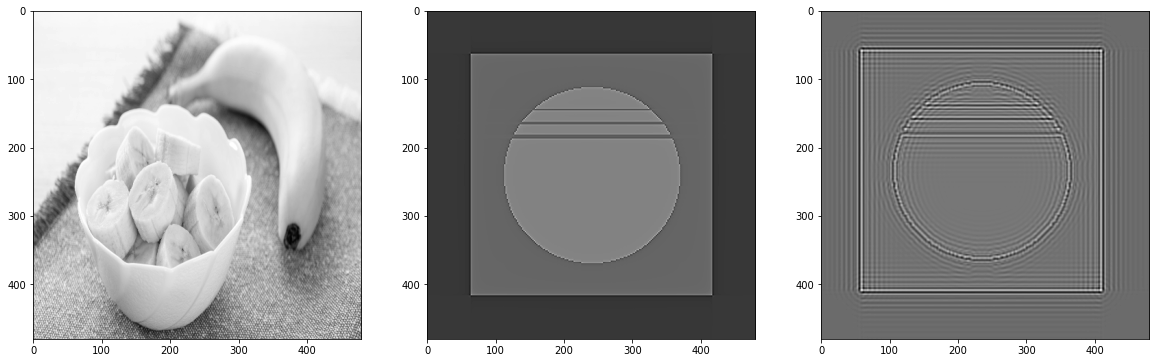

In [21]:
Y =0.00025#initial estimate of Y
p = np.array([(0, -1, 0),
              (-1, 4, -1),
              (0, -1, 0)])
p_padded = np.zeros(im_noise.shape) 
p_padded[:p.shape[0],:p.shape[1]] = np.copy(p)
P =  (np.fft.fft2(p_padded))

h_clsf = gaussian_kernel(k=13,sigma = 3)
h_clsf_padded = np.zeros(im_noise.shape)
h_clsf_padded[:h_clsf.shape[0], :h_clsf.shape[1]] = np.copy(h_clsf)
H_clsf = fftn(h_clsf_padded)

G_clsf = fftn(im_noise)

H2 = (abs(H_clsf)**2+Y*(abs(P)**2))/np.conj(H_clsf)
F_clsf = G_clsf/H2
f_clsf = ifftn(F_clsf).real

#plot image
plt.figure(figsize=(20,12))
plt.subplot(131)
plt.imshow(f, cmap='gray')
plt.subplot(132)
plt.imshow(im_noise, cmap='gray')
plt.subplot(133)
plt.imshow(f_clsf, cmap='gray')    



## Geometric Mean Filter


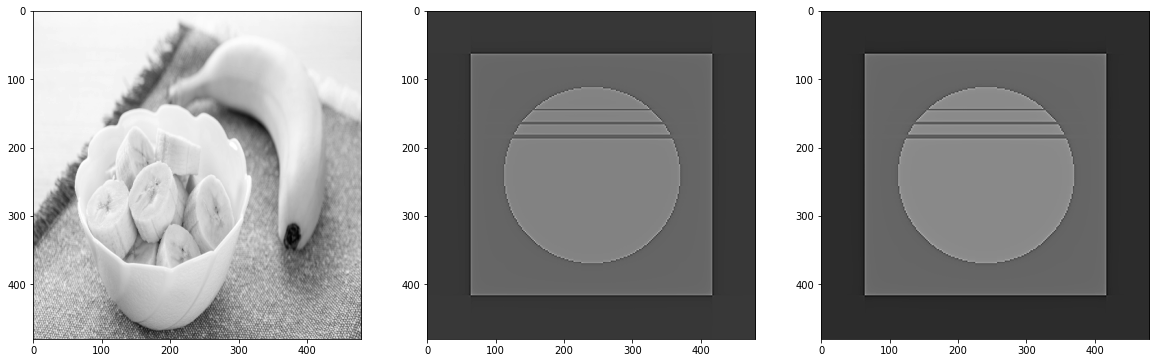

In [22]:
Y =0.0005#initial estimate of Y
K_gmf = 0.000025
alpha = 0.6
beta = 0.7

h_gmf = gaussian_kernel(k=11,sigma = 3)
h_gmf_padded = np.zeros(im_noise.shape)
h_gmf_padded[:h_gmf.shape[0], :h_gmf.shape[1]] = np.copy(h_gmf)
H_gmf = degradation_function(im_noise.shape[0], im_noise.shape[1], K_gmf)
G_gmf = fftn(im_noise)

H_gmf_first_factor = (abs(H_gmf)**2/np.conj(H_gmf))**alpha
H_gmf_second_fator = ((abs(H_gmf)**2+beta*K_gmf)/np.conj(H_gmf))**(1-alpha)
H_gmf_total = H_gmf_first_factor*H_gmf_second_fator
F_clsf = G_clsf/H_gmf_total
f_clsf = ifftn(F_clsf).real

#plot image
plt.figure(figsize=(20,12))
plt.subplot(131)
plt.imshow(f, cmap='gray')
plt.subplot(132)
plt.imshow(im_noise, cmap='gray')
plt.subplot(133)
plt.imshow(f_clsf, cmap='gray')    
